<a href="https://colab.research.google.com/github/Sapi98/metalearning/blob/main/metalearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the necessary libraries

import torch
import torch.nn as nn
from torch.nn.modules import loss
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from copy import deepcopy
from numba import njit, prange, jit
from torchvision import datasets, transforms
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import os
from os import listdir
from torch.multiprocessing import Process, set_start_method
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import gc

gc.collect()
set_start_method('spawn', force=True)
torch.autograd.set_detect_anomaly(True)
torch.cuda.empty_cache()

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initializing few variables
rev_mapping = {'daisy':0, 'tulip':1}
rev_mapping1 = {'airplane':0, 'automobile':1,'bird':0,'cat':1,'deer':0,'dog':1}

In [ ]:
# Checking if GPU is available to train

# CUDA configuration
processor = ''

if torch.cuda.is_available():
    processor = torch.device('cuda')
else:
    processor = torch.device('cpu')

print('Processing is done on', str(processor).upper())

Processing is done on CUDA


In [ ]:
# Initializing few variables

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224])])

batch_size = 32
meta_models = []
epochs = 50
meta_epochs = 1
iterations = 3
model_num = 3
losses = []
loss = None
avg_loss = None
meta_counts = []
meta_files = []

In [ ]:
def getCIFAR10(option='both'):
    # Method to load the CIFAR 10 Dataset

    path = os.path.join(r'/content/drive/My Drive/Metalearning/cifar10/')
    test = []
    train = []
    folders = ['airplane', 'automobile','bird','cat','deer','dog']
    train_dataset_cifar10_first_2 = []
    train_dataset_cifar10_second_2 = []
    train_dataset_cifar10_third_2 = []

    for i in range(6):
        folder = folders[i]
        temp_data = []
        folderpath = path + folder + '/'
        for filename in listdir(folderpath):

            if '.' in filename[0]:
                continue

            image = read_image(folderpath+filename)
            image = transforms.Resize([224,224])(image) / 255

            label = F.one_hot(torch.tensor(rev_mapping1[folder]), num_classes=2)
            label = label.float()

            if i < 2:
                train_dataset_cifar10_first_2.append((image, label))
            elif i >= 2 and i < 4:
                train_dataset_cifar10_second_2.append((image, label))
            elif i >= 4 and i < 6:
                train_dataset_cifar10_third_2.append((image, label))


    # Data loader
    train_loader_cifar10_first_2 = torch.utils.data.DataLoader(dataset=train_dataset_cifar10_first_2,
                                            batch_size=batch_size,
                                            shuffle=True)

    train_loader_cifar10_second_2 = torch.utils.data.DataLoader(dataset=train_dataset_cifar10_second_2,
                                            batch_size=batch_size,
                                            shuffle=True)

    train_loader_cifar10_third_2 = torch.utils.data.DataLoader(dataset=train_dataset_cifar10_third_2,
                                            batch_size=batch_size,
                                            shuffle=True)

    if option == 'first':
        return train_loader_cifar10_first_2

    elif option == 'second':
        return train_loader_cifar10_second_2

    elif option == 'all':
        return (train_loader_cifar10_first_2, train_loader_cifar10_second_2, train_loader_cifar10_third_2)

In [ ]:
def getFlower():
    # Method to load the Flower Dataset

    path = os.path.join(r'/content/drive/My Drive/Metalearning/flowers/')
    test = []
    train = []


    folders = ['daisy', 'tulip']

    for folder in folders:
        count = 0
        temp_data = []
        folderpath = path + folder + '/'
        for filename in listdir(folderpath):
            if count == 55:
                break

            if '.' in filename[0]:
                continue

            image = read_image(folderpath+filename)
            image = transforms.Resize([224,224])(image) / 255

            label = F.one_hot(torch.tensor(rev_mapping[folder]), num_classes=2)
            label = label.float()

            temp_data.append((image, label))

            count += 1

        train.extend(temp_data[:5])
        test.extend(temp_data[5:])

        del temp_data

    train = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    test = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    return train, test

In [ ]:
def generateModel():
    # Method to create Resnet18 models

    processor = ''

    # Checking if GPU is available to train
    if torch.cuda.is_available():
        processor = torch.device('cuda')
    else:
        processor = torch.device('cpu')

    # Creating the model
    model = models.resnet18(pretrained=False)

    # Appending 2 layers to the model
    model = nn.Sequential(model, nn.Linear(1000, 2), nn.Softmax())

    # Configuring the model to be run on GPU using CUDA
    model.to(processor)

    return model

In [ ]:
# Genrate Model

print('Generating Meta Models...')

for i in range(model_num):
    model = generateModel()

    optimizer = torch.optim.Adam(model.parameters())

    meta_models.append((model, optimizer))

print('Meta Models Generated Successfully...')

# Main Model

print('Generating Main Model...')

main_model = generateModel()
main_optimizer = torch.optim.Adam(main_model.parameters())

print('Main Model Generated...')

# Configuration of the loss and optimizer

criterion = nn.CrossEntropyLoss()


Generating Meta Models...
Meta Models Generated Successfully...
Generating Main Model...
Main Model Generated...


In [ ]:
# Get meta dataset
print('Loading Meta Datasets...')
meta_data = getCIFAR10(option='all')
print('Meta Datasets Loaded...')

# Get main dataset
print('Loading Main Datasets...')
main_train_data, main_test_data = getFlower()
print('Main Datasets Loaded...')

Loading Meta Datasets...
Meta Datasets Loaded...
Loading Main Datasets...
Main Datasets Loaded...


In [ ]:
def initializeParameters(meta_models, main_model):
    # Initialize the parameters of the maeta models

    for model, _ in meta_models:
        model.load_state_dict(main_model.state_dict())

In [ ]:
def metafit(model, optimizer, train_data, k, epoch, meta_epoch):
    # Meta Training

    model.train()

    for i, (inputs, labels) in enumerate(train_data):
        # Configuring the input to perform execution on GPU using CUDA
        inputs = inputs.to(processor)
        labels = labels.to(processor)

        # Forward pass
        outputs = model(inputs)

        # Calculating Loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

        print(epoch, meta_epoch, i, meta_counts[k], loss.item(), sep=',', file=meta_files[k])

        meta_counts[k] += 1

In [ ]:
def initCountAndFile(n):
    # Method to initialize the files and count values

    global meta_paths, meta_files

    path = os.path.join(r'/content/drive/My Drive/Metalearning/')

    for i in range(n):
        meta_counts.append(0)

        filename = path + 'record_' + str(i) + '.csv'

        f = open(filename, 'w')

        print('Epoch,Meta Epoch,MiniBatch No,Count,Loss', file=f)

        meta_files.append(f)

In [ ]:
def fit():
    # Method to execute the training process

    global loss, losses, meta_counts, meta_files

    path = os.path.join(r'/content/drive/My Drive/Metalearning/')
    count = 0

    # Initializing files and counts

    initCountAndFile(model_num)

    main_record = open(path+'record.csv', 'w')
    main_test_record = open(path+'test_record.csv', 'w')

    print('Epoch,Iteration,MiniBatch No,Count,Loss', file=main_record)
    print('Epoch,Iteration,MiniBatch No,Count,Precision,Recall,F1,Accuracy', file=main_test_record)

    # Training Epochs

    for i in range(epochs):

        print('Epoch :', i)

        # Meta initialization

        initializeParameters(meta_models, main_model)

        # Training metamodels

        for j in range(meta_epochs):

            print('Meta Epoch :', j)

            for k in range(model_num):
                metafit(meta_models[k][0],meta_models[k][1], meta_data[k], k, i, j)

        # Main Training

        main_model.train()

        for k in range(iterations):
            for j, (inputs, labels) in enumerate(main_train_data):
                losses = []
                inputs = inputs.to(processor)
                labels = labels.to(processor)

                if k == 0:
                    for model, _ in meta_models:
                        output = model(inputs)
                        loss = criterion(output, labels)

                        losses.append(loss)

                    loss = (losses[0] + losses[1] + losses[2]) / model_num

                else:
                    output = main_model(inputs)
                    loss = criterion(output, labels)

                main_optimizer.zero_grad()
                loss.backward()
                main_optimizer.step()

                del losses

                print(i, k, j, count, loss.item(), sep=',', file=main_record)

                if count % 100 == 0:
                    print('Epoch :', i, 'Iteration :', k, 'Loss :', loss.item())

                if count % 2 == 0:
                    precision, recall, f1, acc = evaluate(main_model, main_test_data)
                    print(i, k, j, count, precision*100, recall*100, f1*100, acc*100, sep=',', file=main_test_record)

                count += 1

    main_record.close()
    main_test_record.close()

    for f in meta_files:
        f.close()

    # Saving the trained meta models
    print('\nSaving the trained meta model.....\n')
    for i in range(model_num):
        torch.save(meta_models[i][0].state_dict(), '/content/drive/My Drive/Metalearning/parameters'+str(i)+'.pt')
    print('\nMeta models is saved\n')

    # Saving the trained model
    print('\nSaving the trained model.....\n')
    torch.save(main_model.state_dict(), '/content/drive/My Drive/Metalearning/parameters.pt')
    print('\nModel is saved\n')

In [ ]:
def evaluate(model, test_dataset):
    # Evaluating the main model to analyse the performance on the test set

    model.eval()

    with torch.no_grad():
        total = 0
        pred = []
        true = []

        for _, (images, labels) in enumerate(test_dataset):
            images = images.to(processor)
            labels = labels.to(processor)
            outputs = model(images)
            predicted = torch.argmax(outputs, axis=1)
            total += predicted.size(0)
            truth = torch.argmax(labels, axis=1)

            pred.extend(predicted.tolist())
            true.extend(truth.tolist())

        # Evaluation Scores
        precision = precision_score(true, pred, average='weighted')
        recall = recall_score(true, pred, average='weighted')
        f1 = f1_score(true, pred, average='weighted')
        acc = accuracy_score(true, pred)

        return precision, recall, f1, acc

In [ ]:
fit()

Epoch : 0
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 0 Iteration : 0 Loss : 0.830388069152832


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 1
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 2
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 3
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 4
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 5
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 6
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 7
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 8
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 9
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 10
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 11
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 12
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 13
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 14
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 15
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 16
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 17
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 18
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 19
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 20
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 21
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 22
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 23
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 24
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 25
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 26
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 27
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 28
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 29
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 30
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 31
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 32
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 33
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 33 Iteration : 1 Loss : 0.48146864771842957


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 34
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 35
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 36
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 37
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 38
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 39
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 40
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 41
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 42
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 43
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 44
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

Epoch : 45
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 46
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 47
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 48
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 49
Meta Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Saving the trained meta model.....


Meta models is saved


Saving the trained model.....


Model is saved



In [ ]:
# Evaluating the trained main model on test dataset

main_model.load_state_dict(torch.load(r'/content/drive/My Drive/Metalearning/parameters.pt', map_location=torch.device('cuda')))

precision, recall, f1, acc = evaluate(main_model, main_test_data)

print('Precision :', precision)
print('Recall :', recall)
print('F1 Score :', f1)
print('Accuracy :', acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Precision : 0.5
Recall : 0.5
F1 Score : 0.35031185031185025
Accuracy : 0.5


In [ ]:
# Importing few plotting libraries and loading the saved records

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = os.path.join(r'/content/drive/My Drive/Metalearning/')

main_records = pd.read_csv(path + 'record.csv')
main_test_records = pd.read_csv(path + 'test_record.csv')

meta_records = []

for i in range(model_num):
    record = pd.read_csv(path + 'record_' + str(i) + '.csv')
    meta_records.append(record)

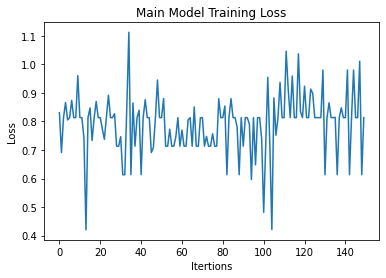

In [ ]:
# Plotting results

plt.plot(main_records['Count'], main_records['Loss'], label='Training Loss')
plt.title('Main Model Training Loss')
plt.xlabel('Itertions')
plt.ylabel('Loss')
plt.savefig(path + 'main_training_loss.png', dpi=600)

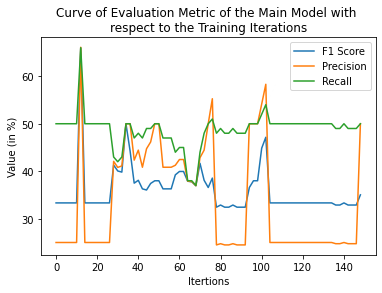

In [ ]:
# Plotting results

plt.plot(main_test_records['Count'], main_test_records['F1'], label='F1 Score')
plt.plot(main_test_records['Count'], main_test_records['Precision'], label='Precision')
plt.plot(main_test_records['Count'], main_test_records['Recall'], label='Recall')
plt.title('Curve of Evaluation Metric of the Main Model with \nrespect to the Training Iterations')
plt.xlabel('Itertions')
plt.ylabel('Value (in %)')
plt.legend()
plt.savefig(path + 'main_evaluation_metric.png', dpi=600)

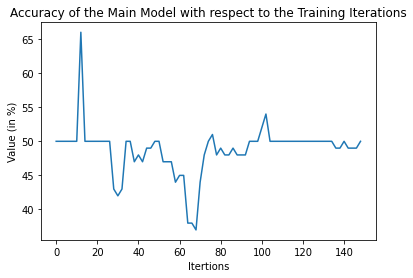

In [ ]:
# Plotting results

plt.plot(main_test_records['Count'], main_test_records['Accuracy'], label='Accuracy')
plt.title('Accuracy of the Main Model with respect to the Training Iterations')
plt.xlabel('Itertions')
plt.ylabel('Value (in %)')
plt.savefig(path + 'main_accuracy.png', dpi=600)

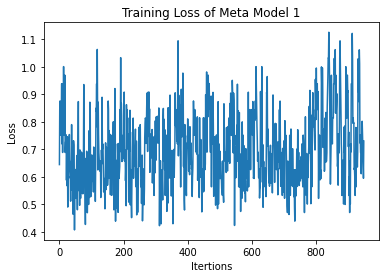

In [ ]:
# Plotting results

plt.plot(meta_records[0]['Count'], meta_records[0]['Loss'], label='Meta-Training Loss')
plt.title('Training Loss of Meta Model 1')
plt.xlabel('Itertions')
plt.ylabel('Loss')
plt.savefig(path + 'meta_training_loss_1.png', dpi=600)

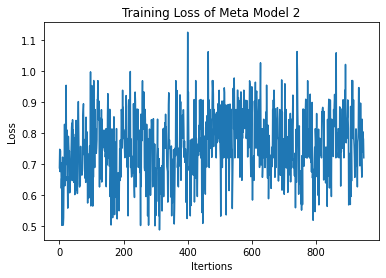

In [ ]:
# Plotting results

plt.plot(meta_records[1]['Count'], meta_records[1]['Loss'], label='Meta-Training Loss')
plt.title('Training Loss of Meta Model 2')
plt.xlabel('Itertions')
plt.ylabel('Loss')
plt.savefig(path + 'meta_training_loss_2.png', dpi=600)

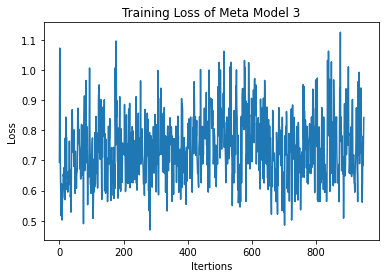

In [ ]:
# Plotting results

plt.plot(meta_records[2]['Count'], meta_records[2]['Loss'], label='Meta-Training Loss')
plt.title('Training Loss of Meta Model 3')
plt.xlabel('Itertions')
plt.ylabel('Loss')
plt.savefig(path + 'meta_training_loss_3.png', dpi=600)